# OCR Training with Apple MPS Acceleration

This notebook implements an Optical Character Recognition (OCR) system optimized for Apple Silicon processors (M1/M2/M3) using Metal Performance Shaders (MPS).

## Configuration Overview

**Hardware Acceleration:**
- MPS device acceleration for Apple Silicon
- CPU fallback for CTC loss computation


**Model Parameters:**- Format: Images with corresponding labels in CSV

- Image dimensions: 64 x 1024 pixels- Location: `./2/dataset/`

- Batch size: 16**Dataset:**

- Training epochs: 40 (with early stopping)

- Patience: 12 epochs- AdamW optimizer with weight decay

- Conservative learning rate with OneCycleLR scheduler

**Training Strategy:**- Light data augmentation optimized for text

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import ollama
import torch.optim as optim
import json
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
import math
import random
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# MPS setup for Apple Silicon
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using Apple MPS (Metal Performance Shaders)')
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA')
else:
    device = torch.device('cpu')
    print('Using CPU')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
        
set_seed(42)
print(f'Device: {device}\n')

✅ Using Apple MPS (Metal Performance Shaders)
Device: mps



## Load Local Dataset

In [2]:
# Local paths
BASE_PATH = './2/dataset/'
IMG_DIR = os.path.join(BASE_PATH, 'images')
labels_path = os.path.join(BASE_PATH, 'labels.csv')

print(f'Loading from: {BASE_PATH}')
print(f'Images dir: {IMG_DIR}')
print(f'Labels: {labels_path}\n')

df = pd.read_csv(labels_path)
print(f'Total rows in CSV: {len(df)}')

# Clean data
df = df[df['text'].notna()].reset_index(drop=True)
df = df[df['text'].str.strip() != ''].reset_index(drop=True)

# Filter by length
MAX_TEXT_LEN = 130
df = df[df['text'].str.len() <= MAX_TEXT_LEN].reset_index(drop=True)

# Verify images exist
df['img_path'] = df['file_name'].apply(lambda x: os.path.join(IMG_DIR, x))
df['exists'] = df['img_path'].apply(os.path.isfile)
df = df[df['exists']].reset_index(drop=True)

print(f'Valid samples: {len(df)}')
print(f'Max text length: {df["text"].str.len().max()}')
print(f'\nSample entry:')
print(df.iloc[0]['text'][:100])

Loading from: ./2/dataset/
Images dir: ./2/dataset/images
Labels: ./2/dataset/labels.csv

Total rows in CSV: 20000
Valid samples: 6137
Max text length: 130

Sample entry:
LIST_0 ← [ 55 , 53 , 55 , 50 ]
VAR_0 ← taille ( LIST_0 )


## Build Vocabulary

In [3]:
# Extract all unique characters
unique_chars = sorted(set(''.join(df['text'].tolist())))
char_list = ['<blank>'] + unique_chars  # blank for CTC
char_to_idx = {ch: i for i, ch in enumerate(char_list)}
idx_to_char = {i: ch for i, ch in enumerate(char_list)}
vocab_size = len(char_list)

print(f'Vocabulary size: {vocab_size}')
print(f'Characters: {"".join(unique_chars[:50])}...')

Vocabulary size: 57
Characters: 	
 ()*+,-/0123456789<=>ADILRSTVX[]_adefghilmnopqrs...


## Training Configuration

Define the hyperparameters for model training and image preprocessing.

In [ ]:
# Image configuration
IMG_HEIGHT = 64
IMG_WIDTH = 1024  # Optimized for stability and memory efficiency

# Training configuration
BATCH_SIZE = 16
NUM_EPOCHS = 40
PATIENCE = 12

print(f'Image size: {IMG_HEIGHT}x{IMG_WIDTH}')
print(f'Expected sequence length: ~{IMG_WIDTH // 4}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Epochs: {NUM_EPOCHS} (patience: {PATIENCE})')

Image size: 64x1024
Expected sequence length: ~256
Batch size: 16
Epochs: 40 (patience: 12)


## Dataset and DataLoader Setup

Implement custom dataset class and configure data transformations for training and validation.

In [5]:
class OCRDataset(Dataset):
    def __init__(self, dataframe, char_to_idx, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.char_to_idx = char_to_idx
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['img_path']).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        encoded = [self.char_to_idx[ch] for ch in row['text']]
        return img, torch.tensor(encoded, dtype=torch.long), len(encoded)

def collate_fn(batch):
    imgs, texts, lens = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    lens = torch.tensor(lens, dtype=torch.long)
    max_len = max(lens)
    padded = torch.zeros(len(texts), max_len, dtype=torch.long)
    for i, text in enumerate(texts):
        padded[i, :len(text)] = text
    return imgs, padded, lens

# Light augmentation - text friendly
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1, hue=0.0)
    ], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 0.5))], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Split 80/20
train_size = int(0.8 * len(df))
val_size = len(df) - train_size

train_idx, val_idx = random_split(
    range(len(df)), [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_ds = OCRDataset(df.iloc[train_idx.indices], char_to_idx, train_transform)
val_ds = OCRDataset(df.iloc[val_idx.indices], char_to_idx, val_transform)

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_ds, BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

print(f'Train: {len(train_ds)}, Val: {len(val_ds)}')
print(f'Train batches: {len(train_loader)}, Val batches: {len(val_loader)}')

Train: 4909, Val: 1228
Train batches: 307, Val batches: 77


## Model Architecture

- Linear projection to vocabulary size

Define the OCR model architecture combining CNN feature extraction with Transformer encoder.- Transformer encoder layers for context modeling

- Positional encoding for sequence information

**Components:**- CNN backbone for visual feature extraction

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class ImprovedOCR(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nhead=8, num_layers=4):
        super().__init__()
        
        # CNN backbone
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x512
            
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x256
            
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, None))  # 1xW
        )
        
        self.proj = nn.Linear(512, hidden_dim)
        self.pos_enc = PositionalEncoding(hidden_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=nhead, 
            dim_feedforward=hidden_dim * 4,
            dropout=0.2, activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.conv(x)  # [B, 512, 1, W]
        x = x.squeeze(2).permute(0, 2, 1)  # [B, W, 512]
        x = self.proj(x)
        x = self.pos_enc(x)
        x = self.transformer(x)
        x = self.norm(x)
        x = self.fc(x)
        return x.permute(1, 0, 2)  # [T, B, C] for CTC

model = ImprovedOCR(num_classes=vocab_size, hidden_dim=256, nhead=8, num_layers=4).to(device)

params = sum(p.numel() for p in model.parameters())
print(f'Model loaded successfully')
print(f'Total parameters: {params:,}')

# Test forward pass
test_in = torch.randn(2, 3, IMG_HEIGHT, IMG_WIDTH).to(device)
test_out = model(test_in)
print(f'Output shape: {test_out.shape}  (T={test_out.shape[0]}, B={test_out.shape[1]}, C={test_out.shape[2]})')

✅ Model loaded
Parameters: 5,449,017
Output shape: torch.Size([256, 2, 57])  (T=256, B=2, C=57)


## Training Setup

Configure loss function, optimizer, and learning rate scheduler. Define utility functions for decoding predictions and calculating accuracy.

In [ ]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.3
)

def decode(logits, idx_to_char):
    preds = []
    logits = logits.permute(1, 0, 2)
    for i in range(logits.size(0)):
        indices = torch.argmax(logits[i], dim=-1).tolist()
        decoded, prev = [], None
        for idx in indices:
            if idx != 0 and idx != prev:
                decoded.append(idx_to_char.get(idx, ''))
            prev = idx
        preds.append(''.join(decoded))
    return preds

def accuracy(preds, targets, lens):
    total, correct = 0, 0
    for pred, target, l in zip(preds, targets, lens):
        true = ''.join([idx_to_char[target[j].item()] for j in range(l)])
        total += len(true)
        for i, c in enumerate(true):
            if i < len(pred) and pred[i] == c:
                correct += 1
    return correct / total if total > 0 else 0.0

print('Training setup complete')

✅ Training setup complete


## Training Loop

- Skip invalid batches to prevent training crashes

Execute the main training loop with validation at each epoch. The model is trained using CTC loss on CPU (due to MPS compatibility) while keeping the forward pass on MPS for acceleration.- Dynamic learning rate scheduling

- Gradient clipping for stability

**Features:**- Early stopping based on validation accuracy

In [ ]:
best_val_acc = 0.0
best_epoch = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print('Starting training process...\n')

for epoch in range(1, NUM_EPOCHS + 1):
    # TRAIN
    model.train()
    t_loss = 0
    t_preds, t_targets, t_lens = [], [], []
    valid = 0
    skipped = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{NUM_EPOCHS}', leave=False)
    for imgs, targets, lens in pbar:
        imgs = imgs.to(device)
        
        with torch.no_grad():
            test_out = model(imgs[:1])
            seq_len = test_out.size(0)
        
        if (lens > seq_len).any():
            skipped += 1
            continue
        
        optimizer.zero_grad()
        logits = model(imgs)
        in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
        log_probs = F.log_softmax(logits, dim=-1)
        # Move to CPU for CTC loss (MPS doesn't support CTC yet)
        loss = criterion(log_probs.cpu(), targets, in_lens, lens)
        
        if torch.isnan(loss) or torch.isinf(loss) or loss.item() > 100:
            skipped += 1
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        scheduler.step()
        
        t_loss += loss.item()
        valid += 1
        
        with torch.no_grad():
            t_preds.extend(decode(logits.cpu(), idx_to_char))
            t_targets.extend(targets)
            t_lens.extend(lens)
        
        pbar.set_postfix({'loss': f'{loss.item():.3f}'})
    
    if valid == 0:
        print(f'Epoch {epoch}: No valid batches!')
        continue
    
    avg_t = t_loss / valid
    t_acc = accuracy(t_preds, t_targets, t_lens)
    train_losses.append(avg_t)
    train_accs.append(t_acc)
    
    # VAL
    model.eval()
    v_loss = 0
    v_preds, v_targets, v_lens = [], [], []
    valid_v = 0
    
    with torch.no_grad():
        for imgs, targets, lens in val_loader:
            imgs = imgs.to(device)
            logits = model(imgs)
            seq_len = logits.size(0)
            in_lens = torch.full((imgs.size(0),), seq_len, dtype=torch.long)
            
            if (lens > seq_len).any():
                continue
            
            log_probs = F.log_softmax(logits, dim=-1)
            # Move to CPU for CTC loss (MPS doesn't support CTC yet)
            loss = criterion(log_probs.cpu(), targets, in_lens, lens)
            
            if not torch.isnan(loss) and not torch.isinf(loss) and loss.item() < 100:
                v_loss += loss.item()
                valid_v += 1
            
            v_preds.extend(decode(logits.cpu(), idx_to_char))
            v_targets.extend(targets)
            v_lens.extend(lens)
    
    avg_v = v_loss / valid_v if valid_v > 0 else float('inf')
    v_acc = accuracy(v_preds, v_targets, v_lens)
    val_losses.append(avg_v)
    val_accs.append(v_acc)
    
    if v_acc > best_val_acc:
        best_val_acc = v_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_mps_model.pth')
        print(f'New best model: {v_acc*100:.2f}% (epoch {epoch})')
    
    skip_msg = f' | Skip: {skipped}' if skipped > 0 else ''
    print(f'Epoch {epoch:2d}/{NUM_EPOCHS} | Train: {avg_t:.4f}/{t_acc*100:.2f}% | Val: {avg_v:.4f}/{v_acc*100:.2f}%{skip_msg}')
    
    if epoch - best_epoch >= PATIENCE:
        print(f'\nEarly stopping triggered (no improvement for {PATIENCE} epochs)')
        print(f'Best: {best_val_acc*100:.2f}% at epoch {best_epoch}')
        break

print(f'\nTraining complete!')

print(f'Best validation accuracy: {best_val_acc*100:.2f}% (epoch {best_epoch})')
print(f'Best validation accuracy: {best_val_acc*100:.2f}% (epoch {best_epoch})')

🚀 Training on MPS...



✅ Best: 11.74% (epoch 1)
Epoch  1/40 | Train: 2.3835/6.51% | Val: 1.9215/11.74%


✅ Best: 14.19% (epoch 2)
Epoch  2/40 | Train: 1.5951/12.92% | Val: 1.1406/14.19%


✅ Best: 18.00% (epoch 3)
Epoch  3/40 | Train: 0.9694/15.72% | Val: 0.7325/18.00%


✅ Best: 21.79% (epoch 4)
Epoch  4/40 | Train: 0.7001/20.04% | Val: 0.6598/21.79%


✅ Best: 32.29% (epoch 5)
Epoch  5/40 | Train: 0.6053/25.52% | Val: 0.5711/32.29%


Epoch  6/40 | Train: 0.5574/28.08% | Val: 0.5308/26.76%


Epoch  7/40 | Train: 0.5294/29.15% | Val: 0.5524/27.41%


Epoch  8/40 | Train: 0.5129/30.17% | Val: 0.4999/27.66%


Epoch  9/40 | Train: 0.4984/30.52% | Val: 0.5082/31.51%


✅ Best: 33.59% (epoch 10)
Epoch 10/40 | Train: 0.4885/31.00% | Val: 0.4852/33.59%


✅ Best: 34.78% (epoch 11)
Epoch 11/40 | Train: 0.4798/31.66% | Val: 0.4792/34.78%


Epoch 12/40 | Train: 0.4753/31.87% | Val: 0.4792/33.35%


Epoch 13/40 | Train: 0.4682/31.74% | Val: 0.4704/27.58%


Epoch 14/40 | Train: 0.4617/32.29% | Val: 0.4729/33.66%


Epoch 15/40 | Train: 0.4602/31.64% | Val: 0.4670/27.77%


✅ Best: 35.52% (epoch 16)
Epoch 16/40 | Train: 0.4618/31.93% | Val: 0.4613/35.52%


✅ Best: 46.91% (epoch 17)
Epoch 17/40 | Train: 0.4474/31.82% | Val: 0.4484/46.91%


Epoch 18/40 | Train: 0.4377/32.18% | Val: 0.4404/26.02%


Epoch 19/40 | Train: 0.4204/33.64% | Val: 0.4254/32.26%


Epoch 20/40 | Train: 0.3976/33.93% | Val: 0.3960/30.85%


Epoch 21/40 | Train: 0.3513/37.83% | Val: 0.3192/44.25%


✅ Best: 55.87% (epoch 22)
Epoch 22/40 | Train: 0.2519/47.69% | Val: 0.1745/55.87%


✅ Best: 58.68% (epoch 23)
Epoch 23/40 | Train: 0.1606/54.48% | Val: 0.1371/58.68%


✅ Best: 63.28% (epoch 24)
Epoch 24/40 | Train: 0.1228/58.21% | Val: 0.1140/63.28%


✅ Best: 67.40% (epoch 25)
Epoch 25/40 | Train: 0.1048/60.71% | Val: 0.0935/67.40%


Epoch 26/40 | Train: 0.0915/62.67% | Val: 0.0892/67.17%


✅ Best: 69.73% (epoch 27)
Epoch 27/40 | Train: 0.0824/64.92% | Val: 0.0897/69.73%


✅ Best: 70.43% (epoch 28)
Epoch 28/40 | Train: 0.0734/66.42% | Val: 0.0805/70.43%


Epoch 29/40 | Train: 0.0682/68.12% | Val: 0.0805/69.87%


✅ Best: 72.07% (epoch 30)
Epoch 30/40 | Train: 0.0615/69.17% | Val: 0.0812/72.07%


✅ Best: 73.69% (epoch 31)
Epoch 31/40 | Train: 0.0572/70.35% | Val: 0.0773/73.69%


✅ Best: 74.27% (epoch 32)
Epoch 32/40 | Train: 0.0525/70.92% | Val: 0.0760/74.27%


✅ Best: 74.82% (epoch 33)
Epoch 33/40 | Train: 0.0488/72.94% | Val: 0.0731/74.82%


✅ Best: 74.87% (epoch 34)
Epoch 34/40 | Train: 0.0456/73.59% | Val: 0.0748/74.87%


✅ Best: 76.13% (epoch 35)
Epoch 35/40 | Train: 0.0432/74.18% | Val: 0.0725/76.13%


✅ Best: 76.35% (epoch 36)
Epoch 36/40 | Train: 0.0409/75.83% | Val: 0.0729/76.35%


✅ Best: 76.64% (epoch 37)
Epoch 37/40 | Train: 0.0395/75.93% | Val: 0.0718/76.64%


✅ Best: 76.87% (epoch 38)
Epoch 38/40 | Train: 0.0381/76.48% | Val: 0.0726/76.87%


✅ Best: 76.88% (epoch 39)
Epoch 39/40 | Train: 0.0377/76.06% | Val: 0.0730/76.88%


✅ Best: 77.26% (epoch 40)
Epoch 40/40 | Train: 0.0378/76.48% | Val: 0.0716/77.26%

✅ Training complete!
Best validation accuracy: 77.26% (epoch 40)
Best validation accuracy: 77.26% (epoch 40)


## Training Results Visualization

Generate plots showing training and validation loss/accuracy progression over epochs.

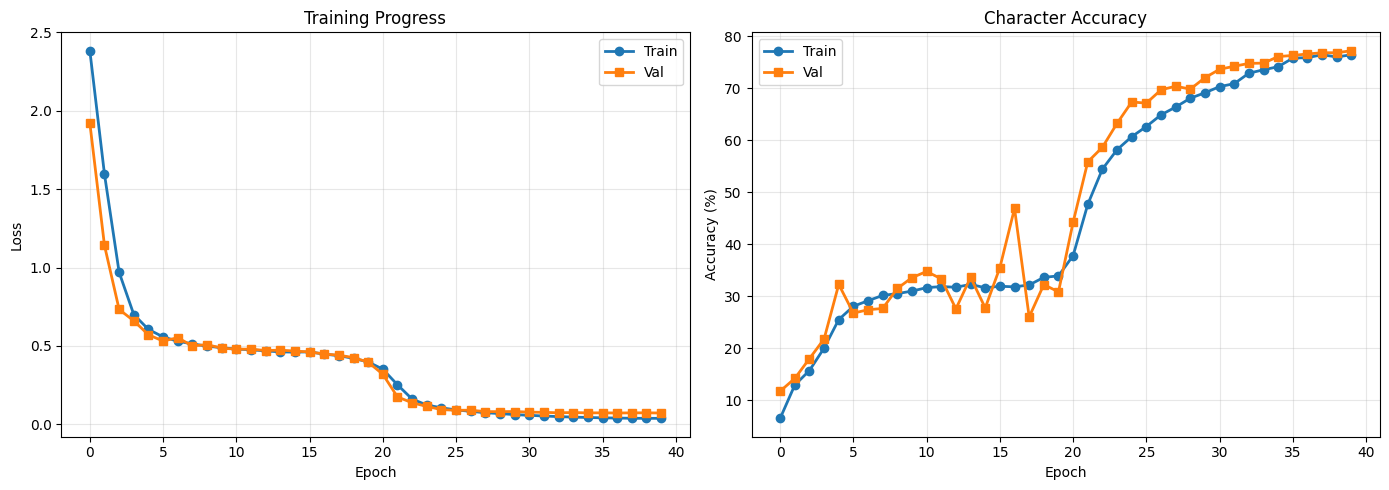

Best: 77.26% at epoch 40


In [13]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'o-', label='Train', lw=2)
plt.plot(val_losses, 's-', label='Val', lw=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot([a*100 for a in train_accs], 'o-', label='Train', lw=2)
plt.plot([a*100 for a in val_accs], 's-', label='Val', lw=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Character Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('mps_training_results.png', dpi=150)
plt.show()

print(f'Best: {best_val_acc*100:.2f}% at epoch {best_epoch}')

## Model Evaluation and Predictions

Load the best model checkpoint and evaluate on the validation set. Display sample predictions with character-level accuracy.

In [ ]:
model.load_state_dict(torch.load('best_mps_model.pth'))
model.eval()

final_preds, final_targets, final_lens = [], [], []

print('Evaluating on validation set...\n')
with torch.no_grad():
    for imgs, targets, lens in tqdm(val_loader, desc='Eval'):
        imgs = imgs.to(device)
        logits = model(imgs)
        final_preds.extend(decode(logits.cpu(), idx_to_char))
        final_targets.extend(targets)
        final_lens.extend(lens)

final_acc = accuracy(final_preds, final_targets, final_lens)

print(f'\nFINAL ACCURACY: {final_acc*100:.2f}%\n')
print('='*100)
print('Sample Predictions:\n')

for i in range(min(15, len(final_preds))):
    true = ''.join([idx_to_char[final_targets[i][j].item()] for j in range(final_lens[i])])
    pred = final_preds[i]
    char_acc = sum(1 for a,b in zip(true, pred) if a==b) / len(true) * 100 if len(true) > 0 else 0
    
    print(f'Sample {i+1:2d} | Acc: {char_acc:5.1f}%')
    print(f'  True: {true[:90]}')
    print(f'  Pred: {pred[:90]}')
    print('-'*100)

print(f'\nFinal Accuracy: {final_acc*100:.2f}%')
print(f'Model saved as: best_mps_model.pth')

Evaluating on validation set...



Eval: 100%|██████████| 77/77 [00:14<00:00,  5.19it/s]


 FINAL ACCURACY: 77.26%

Sample Predictions:

Sample  1 | Acc: 100.0%
  True: algorithme
	VAR_1 ← 80
	VAR_7 ← 94
	VAR_1 ← ( VAR_1 + 110 )
	VAR_3 ← ( VAR_7 / VAR_1 )
fin
  Pred: algorithme
	VAR_1 ← 80
	VAR_7 ← 94
	VAR_1 ← ( VAR_1 + 110 )
	VAR_3 ← ( VAR_7 / VAR_1 )
fin
----------------------------------------------------------------------------------------------------
Sample  2 | Acc: 100.0%
  True: algorithme
	VAR_8 ← 104
	VAR_4 ← 25
	VAR_7 ← ( VAR_8 / 60 )
	VAR_7 ← ( VAR_4 - VAR_7 )
fin
  Pred: algorithme
	VAR_8 ← 104
	VAR_4 ← 25
	VAR_7 ← ( VAR_8 / 60 )
	VAR_7 ← ( VAR_4 - VAR_7 )
fin
----------------------------------------------------------------------------------------------------
Sample  3 | Acc:  46.2%
  True: LIST_5 ← [ 50 , 42 , 47 , 105 , 99 , 39 , 66 , 120 ]
VAR_0 ← taille ( LIST_5 )
  Pred: LIST_5 ← [ 50 , 42 , 47 , 105 , 9 , 39 , 6 , 120 ]
VAR_0 ← taille ( LIST_5 )
----------------------------------------------------------------------------------------------------
Sample  4 

## Export Predictions and Generate Python Code

Save OCR predictions to JSON and use LLaMA to convert French algorithm descriptions to Python code.

In [ ]:
# ================================
# 1) SAVE PREDICTIONS TO FILE
# ================================
results = []

for i in range(len(final_preds)):
    true = ''.join([idx_to_char[final_targets[i][j].item()] for j in range(final_lens[i])])
    pred = final_preds[i]
    char_acc = sum(1 for a, b in zip(true, pred) if a == b) / len(true) * 100 if len(true) > 0 else 0

    results.append({
        "sample": i + 1,
        "true": true,
        "pred": pred,
        "char_acc": char_acc
    })

# Save to JSON
with open("predictions.json", "w", encoding="utf-8") as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

print("Predictions saved to predictions.json\n")


# ================================
# 2) PRINT FORMATTED RESULTS
# ================================
print('=' * 100)

for r in results[:20]:
    print(f"Sample {r['sample']:2d} | Acc: {r['char_acc']:.1f}%")
    print(f"  True: {r['true']}")
    print(f"  Pred: {r['pred']}")
    print('-' * 100)


# ================================
# 3) SEND EACH PRED TO LLAMA -> PYTHON
# ================================
print("\nConverting predictions to Python using LLaMA...\n")

converted_codes = []

for r in results[:6]:  # limit to avoid long runtime
    french_algorithm = r["pred"]

    prompt = f"""
You are an expert programmer. Translate the following algorithm description written in French into Python code. 
Provide only the Python code without additional explanation.

French description:
{french_algorithm}
"""

    response = ollama.chat(
        model='llama3:8b',
        messages=[{'role': 'user', 'content': prompt}]
    )

    python_code = response['message']['content']
    converted_codes.append({
        "sample": r["sample"],
        "python_code": python_code
    })

    print(f"\nSample {r['sample']} -> Python Code:\n")
    print(python_code)
    print('=' * 100)


# ================================
# 4) SAVE GENERATED PYTHON CODES
# ================================
with open("converted_python_codes.json", "w", encoding="utf-8") as f:
    json.dump(converted_codes, f, indent=4, ensure_ascii=False)

print("\nConverted Python codes saved to converted_python_codes.json")


 Predictions saved to predictions.json

Sample  1 | Acc: 100.0%
  True: algorithme
	VAR_1 ← 80
	VAR_7 ← 94
	VAR_1 ← ( VAR_1 + 110 )
	VAR_3 ← ( VAR_7 / VAR_1 )
fin
  Pred: algorithme
	VAR_1 ← 80
	VAR_7 ← 94
	VAR_1 ← ( VAR_1 + 110 )
	VAR_3 ← ( VAR_7 / VAR_1 )
fin
----------------------------------------------------------------------------------------------------
Sample  2 | Acc: 100.0%
  True: algorithme
	VAR_8 ← 104
	VAR_4 ← 25
	VAR_7 ← ( VAR_8 / 60 )
	VAR_7 ← ( VAR_4 - VAR_7 )
fin
  Pred: algorithme
	VAR_8 ← 104
	VAR_4 ← 25
	VAR_7 ← ( VAR_8 / 60 )
	VAR_7 ← ( VAR_4 - VAR_7 )
fin
----------------------------------------------------------------------------------------------------
Sample  3 | Acc: 46.2%
  True: LIST_5 ← [ 50 , 42 , 47 , 105 , 99 , 39 , 66 , 120 ]
VAR_0 ← taille ( LIST_5 )
  Pred: LIST_5 ← [ 50 , 42 , 47 , 105 , 9 , 39 , 6 , 120 ]
VAR_0 ← taille ( LIST_5 )
----------------------------------------------------------------------------------------------------
Sample  4 | Acc: 9